In [116]:
pip install tensorflow pandas matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path dataset
train_dir = "./train"
valid_dir = "./valid"
test_dir = "./test"

IMG_SIZE = (224, 224)

# Baca file anotasi
train_annotations = pd.read_csv(os.path.join(train_dir, "_annotations.csv"))
test_annotations = pd.read_csv(os.path.join(test_dir, "_annotations.csv"))

In [118]:
print(train_annotations.columns)

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


In [119]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Pastikan data dalam rentang [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(train_dir, "_annotations.csv")),
    directory=train_dir,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode="categorical"
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_data = valid_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(valid_dir, "_annotations.csv")),
    directory=valid_dir,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode="categorical",
    shuffle=False  # Urutan tetap untuk validasi
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(test_dir, "_annotations.csv")),
    directory=test_dir,
    x_col="filename",
    y_col="class",  # Jika ada label; gunakan `None` jika tidak ada
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode="categorical",  # Gunakan `None` jika tanpa label
    shuffle=False  # Urutan tetap untuk evaluasi/prediksi
)

Found 9647 validated image filenames belonging to 17 classes.
Found 867 validated image filenames belonging to 17 classes.
Found 471 validated image filenames belonging to 17 classes.


In [120]:
print(f"Jumlah data training: {train_data.samples}")
print(f"Jumlah data validasi: {valid_data.samples}")
print(f"Jumlah data test: {test_data.samples}")

Jumlah data training: 9647
Jumlah data validasi: 867
Jumlah data test: 471


In [121]:
print(f"Kelas pada training data: {train_data.class_indices}")
print(f"Kelas pada validasi data: {valid_data.class_indices}")


Kelas pada training data: {'apel': 0, 'ayam_bakar': 1, 'ayam_goreng': 2, 'brokoli': 3, 'nasi_kuning': 4, 'nasi_putih': 5, 'pisang': 6, 'semangka': 7, 'tahu_kuning': 8, 'tahu_putih': 9, 'telur_balado': 10, 'telur_ceplok': 11, 'telur_dadar': 12, 'telur_rebus': 13, 'tempe': 14, 'timun': 15, 'tomat': 16}
Kelas pada validasi data: {'apel': 0, 'ayam_bakar': 1, 'ayam_goreng': 2, 'brokoli': 3, 'nasi_kuning': 4, 'nasi_putih': 5, 'pisang': 6, 'semangka': 7, 'tahu_kuning': 8, 'tahu_putih': 9, 'telur_balado': 10, 'telur_ceplok': 11, 'telur_dadar': 12, 'telur_rebus': 13, 'tempe': 14, 'timun': 15, 'tomat': 16}


In [122]:
# Ambil batch pertama dari training data
x_batch, y_batch = next(train_data)
print(f"Bentuk batch gambar: {x_batch.shape}")
print(f"Bentuk batch label: {y_batch.shape}")


Bentuk batch gambar: (64, 224, 224, 3)
Bentuk batch label: (64, 17)


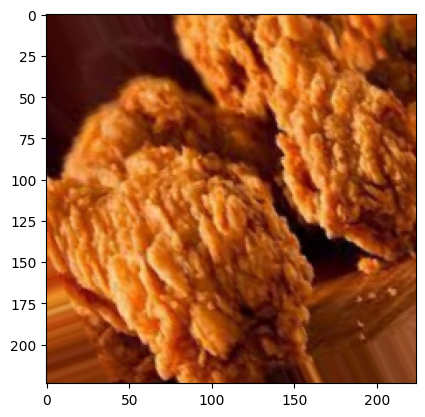

In [123]:
import matplotlib.pyplot as plt
for x_batch, y_batch in train_data:
    plt.imshow(x_batch[0])  # Gambar pertama dalam batch
    plt.show()
    break


In [124]:
print("Jumlah total batch di training data:", len(train_data))
print("Jumlah gambar per batch:", train_data.batch_size)
print("Total gambar training:", len(train_data.filenames))

Jumlah total batch di training data: 151
Jumlah gambar per batch: 64
Total gambar training: 9647


In [125]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 dengan bobot pra-terlatih dari ImageNet, tanpa lapisan akhir (include_top=False)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze semua lapisan di base_model agar tidak dilatih ulang
base_model.trainable = False

# Tambahkan lapisan kustom untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling untuk meratakan keluaran dari base_model
x = Dense(128, activation='relu')(x)  # Lapisan dense tambahan untuk mempelajari pola baru
x = Dense(17, activation='softmax')(x)  # Lapisan output dengan 17 kelas (ubah sesuai kebutuhan)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = []

callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6))


# Tampilkan ringkasan model
# model.summary()


In [126]:
import tensorflow as tf

# # Dataset training
# train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
# train_dataset = train_dataset.shuffle(buffer_size=1000) \
#                              .batch(batch_size=64) \
#                              .repeat()  # Mengulangi dataset tanpa batas

# # Dataset validasi (tanpa shuffle dan tanpa repeat)
# valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
# valid_dataset = valid_dataset.batch(batch_size=64)

# # Tentukan steps_per_epoch
# steps_per_epoch = len(train_data) // 64
# validation_steps = len(valid_data) // 64

# Training
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_steps=len(valid_data),
    callbacks=callbacks
)


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5942 - loss: 1.3877 - val_accuracy: 0.7509 - val_loss: 0.8167 - learning_rate: 0.0010
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


 71/151 ━━━━━━━━━━━━━━━━━━━━ 1:07 838ms/step - accuracy: 0.8118 - loss: 0.5969

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step - accuracy: 0.7554 - loss: 0.7623
Test Loss: 0.7795838713645935, Test Accuracy: 0.7515923380851746


In [ ]:
import numpy as np

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=-1)

# Melihat prediksi
print(predicted_classes)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 594ms/step
[ 2  2  5 13 13  2  2  2  2  6  2  2  2  2  3  6  6  6  6  2  4  4  4 13
 13  6  6  6  5  2  8  6  3  2 13 13 14 14 14 14 14  1 14 14 14 14  6  5
  8  8  8  8  2  2 13 10 10 10  2  2  2  1  1  1  1  0  2  2  2  2 12  5
  7  0  0  0  0  0  2  0  7  7  7  7  5 15 15  2  1  1 10  0 14 14  8  4
  4  4  4  4  4  4  4  4  4  4  2  2  2  2  2  2  2 11 11  0  0  0  2 13
 13 12  2  2  2  2  2  2  2  2  2  0  2  2  2  2  2 14 14 14 14  4  4  4
  4  4 15  1  1 15 15 15  3  3  6  4  4  4  2  2  2  2  9  9  2  2  0 14
 14 14  2  2  2  9  9 12  2  2  2 12 12 12 12 12 12  0  0  0  0  8  8  4
  4  4  4  4  4  2  4  2  6  6  6  1  1 10 10 10  9  9  2  6  6 13 13 13
 13  9  9  9  9  9  9 10 10 10  5 14 14 14 14  3 11  2 14 14 14 14 14  2
 15 15 15 15 15 15 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  8  8  8
  8  8  8  8  8  8  3  3  2  2  8  8  4  4  4  4 13  2  2  8  8  8  2  5
  2  2  2 15 10 10 10  2  2  2  2  4  4 12 12 12  2  2  2  2 11 11 11  2
  2  6  7  7

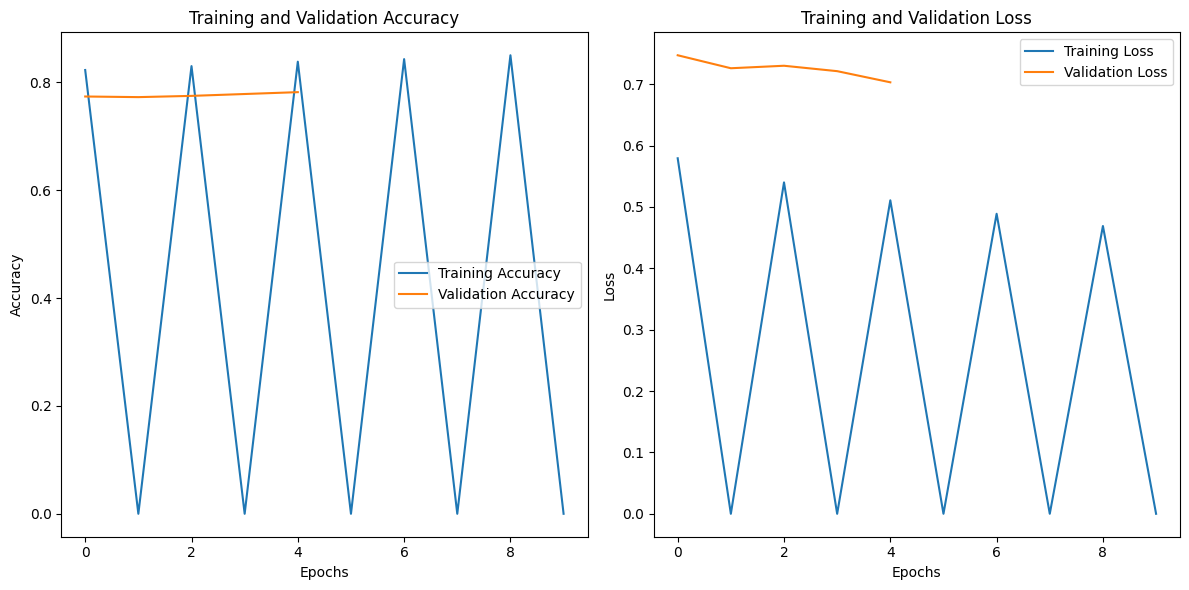

In [ ]:
import matplotlib.pyplot as plt

# Plotting kurva akurasi
plt.figure(figsize=(12, 6))

# Plotting akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()